In [1]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split

import seaborn as sns

sns.set_style('whitegrid')
sns.set_palette('Set2')
sns.color_palette('Set2')
dlsu_green = "#117a65ff"


# Scikitlearn Pipeline

<img src="https://www.tomasbeuzen.com/post/scikit-learn-gridsearch-pipelines/featured_hu078592ed7247fe60b201cf541e7b6db7_204111_720x0_resize_lanczos_3.png">

There are a few key steps that we take prior to building a model. A few of them are: 
    - Feature pre-processing - wherein we prepare our data to be ready for modeling 
    - Feature Selection - selection of features to further simplify our model in the hopes that it will perform better 
    - Model Selection & Hyperparameter tuning - running different machine learning algorithms and hyperparameters to find the optimal model
    
The code that we develop for these can get out of hand especially if we run multiple experiments. To aid us in this, we have the `Pipeline` class from sklearn which allows us to enumerate the steps to be taken from preprocessing to modeling. Using this class helps us maintain our code and simplifies our process further. 

## Create Fake Data

Generate a toy dataset that contains features on height, age, gender wherein the model target is if the person likes pop music or not. We introduce random null values to demonstrate the use of scikitlearn pipeline.

In [2]:
size = 100

data = {"height": np.random.choice(np.arange(150, 200), size),
        "age": np.random.choice(np.arange(20, 50), size),
        "gender": np.random.choice(['male', 'female'], size),
        "likes_pop": np.random.choice([0,1], size)}

toy_data_df = pd.DataFrame(data)
display(toy_data_df.head())

,height,age,gender,likes_pop
0,196,36,male,1
1,182,37,female,1
2,156,42,male,1
3,172,41,male,1
4,173,26,male,0


In [3]:
X = toy_data_df[['height', 'age', 'gender']]
X = X.mask(np.random.random(X.shape) < .3)
y = toy_data_df['likes_pop']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

display(X)

,height,age,gender
0,NaN,36.0,NaN
1,182.0,NaN,NaN
2,156.0,42.0,male
3,172.0,NaN,male
4,NaN,NaN,male
...,...,...,...
95,174.0,49.0,NaN
96,NaN,22.0,NaN
97,166.0,27.0,female
98,175.0,36.0,NaN


## Build Pipeline to handle Missing Data & Categorical Values

In [4]:
from sklearn.pipeline import Pipeline 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

Example of using `SimpleImputer`

Pipeline that uses `SimpleImputer` and `OneHotEncoder`

In [8]:
numeric_imputer = Pipeline(
        steps=[
            ("impute", SimpleImputer(strategy='mean'))
        ]
)

categorical_imputer = Pipeline(
        steps=[
            ("impute", SimpleImputer(strategy='most_frequent')),
            ("one-hot", OneHotEncoder(handle_unknown='ignore', sparse=False))
        ]
)

### Sample of Using the Categorical Imputer on the Toy Dataset

In [9]:
categorical_imputer.fit(X_train[['gender']])

Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                ('one-hot',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

The `steps` attribute contains the instances of the preprocessing done. For example, you can access the names of the features returned from the categorical imputer by going through the steps attribute

In [10]:
categorical_imputer.steps[1][1].get_feature_names()

array(['x0_female', 'x0_male'], dtype=object)


### Sample of Using the Numeric Imputer on the Toy Dataset

In [20]:
numeric_imputer.fit(X_train[['age']])

Pipeline(steps=[('impute', SimpleImputer())])

In [26]:
numeric_imputer.steps[0][1]

SimpleImputer()

In [19]:
numeric_imputer.fit(X_train[['height']])

Pipeline(steps=[('impute', SimpleImputer())])

### How do we stitch the 2 together if we have a lot of features?

Sklearn has the `ColumnTransformer` estimator. This estimator allows different columns or column subsets of the input to be transformed separately and the features generated by each transformer will be concatenated to form a single feature space. 

In [1]:
from sklearn.compose import ColumnTransformer



We can access the different transformers/steps using the `transformers` attribute

In [14]:
num_cat_imputer.transformers

[('numeric', Pipeline(steps=[('impute', SimpleImputer())]), ['height', 'age']),
 ('categorical',
  Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                  ('one-hot',
                   OneHotEncoder(handle_unknown='ignore', sparse=False))]),
  ['gender'])]

### Building a Pipeline from Preprocessing up to Modeling

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score

log_reg = LogisticRegression()

logreg_pipeline = Pipeline(steps=[
    ('preprocess', num_cat_imputer),
    ('model', log_reg)
])

logreg_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer())]),
                                                  ['height', 'age']),
                                                 ('categorical',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['gender'])])),
                ('model', LogisticRegression())])

In [16]:
y_pred = logreg_pipeline.predict(X_test)

print(f"Test acc:{logreg_pipeline.score(X_test, y_test)}")
print(f"Test Precision:{precision_score(y_test, y_pred)}")
print(f"Test Recall:{recall_score(y_test, y_pred)}")

Test acc:0.7
Test Precision:0.75
Test Recall:0.375


### Optimizing the pipeline by including Gridsearch

Since the pipeline attribute provides the score or scoring function we can use our pipeline as part of our gridsearch

In [17]:
from sklearn.model_selection import GridSearchCV

param_dict = {'model__C': [0, 0.1, 0.001, 0.0001, 1],
              'model__penalty': ['l1', 'l2'],
              'model__solver': ['liblinear']}

search = GridSearchCV(logreg_pipeline, param_dict, cv=10)
search.fit(X_train, y_train)

C:\Users\Sashmir Yap\Miniconda3\envs\dsi\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sashmir Yap\Miniconda3\envs\dsi\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sashmir Yap\Miniconda3\envs\dsi\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Sashmir Yap\Miniconda3\envs\dsi\lib\site-packages\sklearn\linear_model\_logistic.py", line 1362, in fit
    sample_weight=sample_weight)
  File "C:\Users\Sashmir Yap\Miniconda3\envs\dsi\lib\site-packages\sklearn\svm\_base.py", line 978, in _fit_liblinear
    epsilon, sample_weight)
  File "sklearn\svm\_liblinear.pyx", line 52, in sklearn.svm._liblinear.train_w

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer())]),
                                                                         ['height',
                                                                          'age']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('one-hot',
                                            

In [20]:
search.best_estimator_

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer())]),
                                                  ['height', 'age']),
                                                 ('categorical',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['gender'])])),
                ('model', LogisticRegression(C=0.001, solver='liblinear'))

In [21]:
y_pred = search.best_estimator_.predict(X_test)

print(f"Test acc:{search.best_estimator_.score(X_test, y_test)}")
print(f"Test Precision:{precision_score(y_test, y_pred)}")
print(f"Test Recall:{recall_score(y_test, y_pred)}")


Test acc:0.6
Test Precision:0.0
Test Recall:0.0


C:\Users\Sashmir Yap\Miniconda3\envs\dsi\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Adding more models to the pipeline

In [22]:
from sklearn.ensemble import RandomForestClassifier

param_dict = [
    {
        'classifier': [LogisticRegression()],
        'classifier__C': [0.1, 0.001, 0.0001, 1],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear']     
    },
    {
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': range(100, 200, 20),
        'classifier__max_depth': range(10,50,10),
        'classifier__min_samples_split': np.arange(0.1,.6,.1),
        'classifier__min_samples_leaf': np.arange(0.1,.6,.1),
        'classifier__max_features': np.arange(0.1,.6,.1)
    }
]

pipeline = Pipeline(steps=[
    ('preprocess', num_cat_imputer),
    ('classifier', LogisticRegression())
])

search = GridSearchCV(pipeline, param_dict, cv=10, verbose=0)
search.fit(X_train, y_train)


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer())]),
                                                                         ['height',
                                                                          'age']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('one-hot',
                                            

In [23]:
result_df = pd.DataFrame.from_dict(search.cv_results_, orient='columns')
result_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__C,param_classifier__penalty,param_classifier__solver,param_classifier__max_depth,param_classifier__max_features,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.008288,0.000634,0.003993,0.000019,LogisticRegression(),0.1,l1,liblinear,NaN,NaN,...,0.625,0.625,0.625,0.750,0.625,0.500,0.625,0.6125,0.067315,273
1,0.007647,0.000449,0.003786,0.000389,LogisticRegression(),0.1,l2,liblinear,NaN,NaN,...,0.500,0.625,0.625,0.625,0.625,0.375,0.625,0.5750,0.082916,2499
2,0.007880,0.000544,0.003785,0.000405,LogisticRegression(),0.001,l1,liblinear,NaN,NaN,...,0.625,0.625,0.625,0.625,0.625,0.625,0.625,0.6125,0.037500,273
3,0.008053,0.000325,0.004083,0.000538,LogisticRegression(),0.001,l2,liblinear,NaN,NaN,...,0.625,0.750,0.625,0.750,0.625,0.625,0.625,0.6375,0.067315,26
4,0.008381,0.000661,0.004563,0.000611,LogisticRegression(),0.0001,l1,liblinear,NaN,NaN,...,0.625,0.625,0.625,0.625,0.625,0.625,0.625,0.6125,0.037500,273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,0.102632,0.002114,0.011363,0.000467,"RandomForestClassifier(max_depth=10, max_featu...",NaN,NaN,NaN,40,0.5,...,0.625,0.625,0.625,0.625,0.625,0.625,0.625,0.6125,0.037500,273
2504,0.124009,0.005835,0.012615,0.000690,"RandomForestClassifier(max_depth=10, max_featu...",NaN,NaN,NaN,40,0.5,...,0.625,0.625,0.625,0.625,0.625,0.625,0.625,0.6125,0.037500,273
2505,0.140427,0.001905,0.013849,0.000297,"RandomForestClassifier(max_depth=10, max_featu...",NaN,NaN,NaN,40,0.5,...,0.625,0.625,0.625,0.625,0.625,0.625,0.625,0.6125,0.037500,273
2506,0.161734,0.005904,0.015579,0.000667,"RandomForestClassifier(max_depth=10, max_featu...",NaN,NaN,NaN,40,0.5,...,0.625,0.625,0.625,0.625,0.625,0.625,0.625,0.6125,0.037500,273


In [36]:
result_df.param_classifier.unique()[1]

RandomForestClassifier(max_depth=10, max_features=0.5, min_samples_leaf=0.1,
                       min_samples_split=0.1, n_estimators=180)

<AxesSubplot:xlabel='param_classifier', ylabel='mean_test_score'>

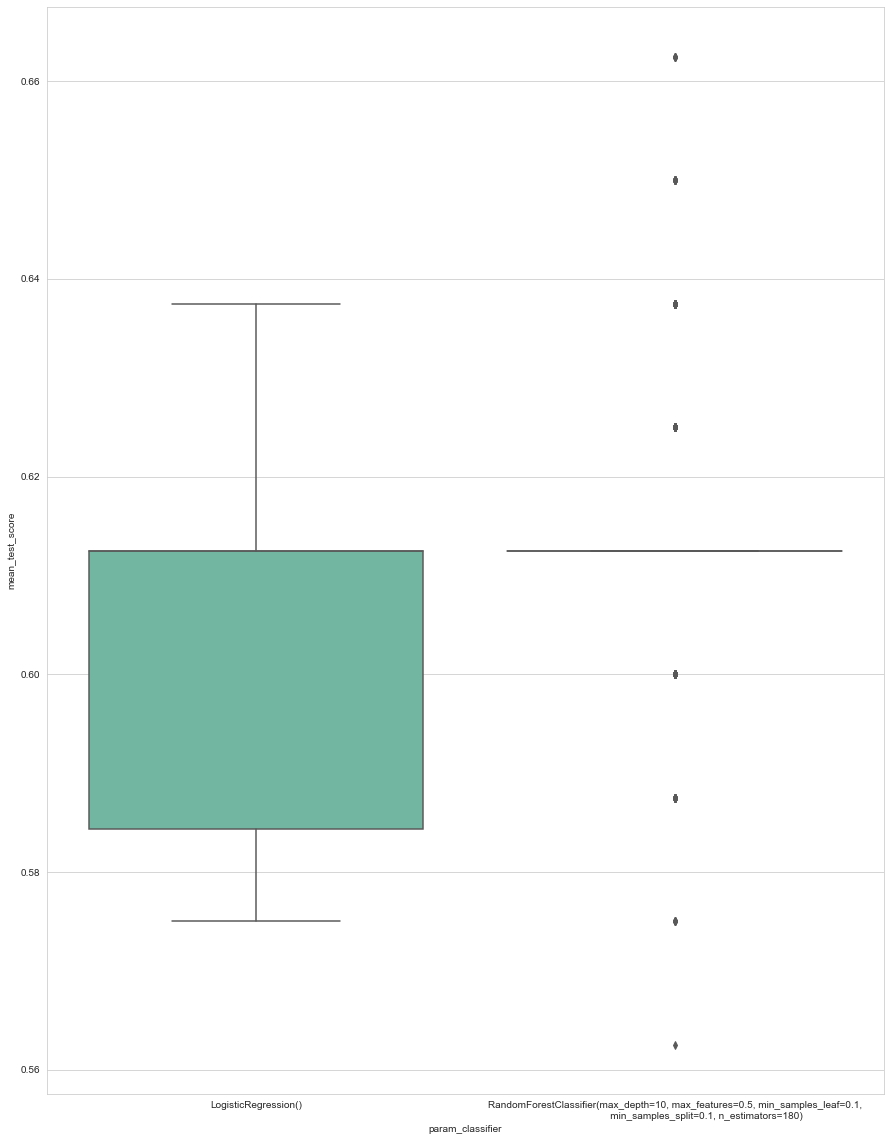

In [27]:
import matplotlib.pyplot as plt
ax, fig = plt.subplots(figsize=(15,20))
sns.boxplot(data=result_df, x="param_classifier", y="mean_test_score")

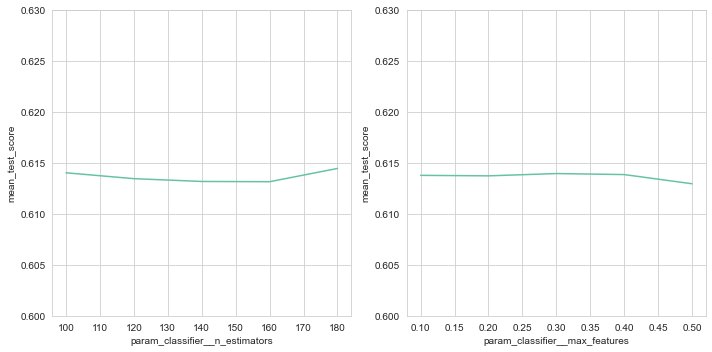

In [59]:
fig, axes = plt.subplots(figsize=(10,5), ncols=2)
sns.lineplot(data=result_df[result_df.param_classifier == result_df.param_classifier.unique()[1]], 
            x="param_classifier__n_estimators", y="mean_test_score", ci=None, ax=axes[0])

sns.lineplot(data=result_df[result_df.param_classifier == result_df.param_classifier.unique()[1]], 
            x="param_classifier__max_features", y="mean_test_score", ci=None, ax=axes[1])

axes[0].set_ylim(0.6, 0.63)
axes[1].set_ylim(0.6, 0.63)

plt.tight_layout()

In [71]:
search.best_estimator_.steps[0][1].transform(X_train)

array([[152.        ,  49.        ,   1.        ,   0.        ],
       [180.        ,  34.        ,   0.        ,   1.        ],
       [183.        ,  36.        ,   1.        ,   0.        ],
       [174.47540984,  39.        ,   1.        ,   0.        ],
       [175.        ,  36.        ,   0.        ,   1.        ],
       [177.        ,  36.        ,   1.        ,   0.        ],
       [199.        ,  40.        ,   1.        ,   0.        ],
       [196.        ,  46.        ,   0.        ,   1.        ],
       [178.        ,  28.        ,   1.        ,   0.        ],
       [150.        ,  29.        ,   1.        ,   0.        ],
       [189.        ,  26.        ,   0.        ,   1.        ],
       [156.        ,  36.        ,   1.        ,   0.        ],
       [164.        ,  36.        ,   1.        ,   0.        ],
       [181.        ,  36.        ,   1.        ,   0.        ],
       [183.        ,  32.        ,   1.        ,   0.        ],
       [178.        ,  46

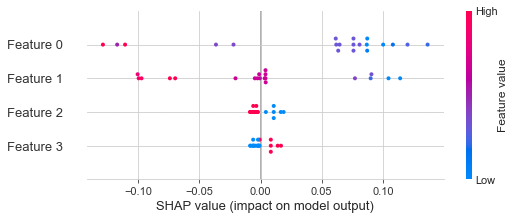

In [77]:
import shap
explainer = shap.TreeExplainer(search.best_estimator_.steps[1][1], 
                               search.best_estimator_.steps[0][1].transform(X_train),
                               feature_perturbation='interventional',
                               model_output='probability')
shap_values = explainer.shap_values(search.best_estimator_.steps[0][1].transform(X_test))
shap.summary_plot(shap_values[0], search.best_estimator_.steps[0][1].transform(X_test))

## Group Activity

In your groups, build a pipeline using sklearn that cleans the titanic dataset and creates a model that classifies if a passenger survives or dies. 

Prior to building the pipeline drop the following columns:
- PassengerId 
- Cabin (77% of data points are missing) 
- Name <br>

For age impute the missing data by getting the average while for embarked get the most frequent value. 

In [78]:
titanic_df = pd.read_csv("../data/titanic.csv")
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [80]:
titanic_df.isnull().sum()/titanic_df.shape[0]

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64